In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import make_pipeline
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity_cosine"

In [3]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [4]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [5]:
degree = 1
l2_reg = 0.01

In [6]:
p = 2
targets = np.array([212])
nontargets = np.array([220])

p_thr = 2/19
p_upper = 1
random_state = 0

In [9]:
def getWeights(p, n, degree, l2_reg=0.01):
    poly = PolynomialFeatures(degree)
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)
    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]

    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(amplitudes[:, 0][good_inds], 
                amplitudes[:, 1][good_inds],
                amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)
    # ax.scatter(x.value[0], x.value[1], x.value[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()

    clustering = SpectralClustering(n_clusters=2, 
                                    assign_labels='discretize',
                                    affinity='nearest_neighbors', 
                                    random_state=random_state).fit(X)

    cluster1 = np.where(clustering.labels_ == 0)[0]
    cluster2 = np.where(clustering.labels_ == 1)[0]

    X_pos = X[cluster1]
    X_neg = X[cluster2]

    y_pos = y[cluster1]
    y_neg = y[cluster2]

    OLS_X_neg = poly.fit_transform(X_neg)
    OLS_y_neg = np.log(y_neg / (1 - y_neg))

    OLS_w_neg = (np.linalg.inv(l2_reg * np.eye(OLS_X_neg.shape[-1]) + OLS_X_neg.T @ OLS_X_neg) @ OLS_X_neg.T) @ OLS_y_neg

    OLS_X_pos = poly.fit_transform(X_pos)
    OLS_y_pos = np.log(y_pos / (1 - y_pos))

    OLS_w_pos = (np.linalg.inv(l2_reg * np.eye(OLS_X_pos.shape[-1]) + OLS_X_pos.T @ OLS_X_pos) @ OLS_X_pos.T) @ OLS_y_pos

    return np.vstack((OLS_w_neg, OLS_w_pos))

OFF parasol


/tmp/ipykernel_33629/1071674922.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


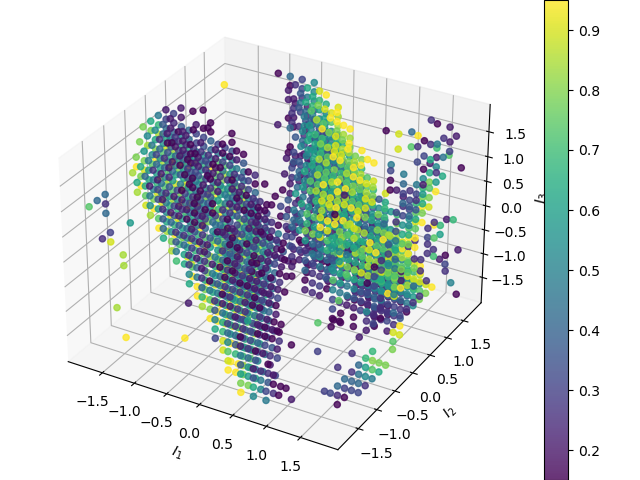

In [12]:
nt_weights = []
for nt in nontargets:
    print(vcd.get_cell_type_for_cell(nt))
    nt_weights.append(getWeights(p, nt, degree, l2_reg))

nt_weights = np.vstack((nt_weights))

In [13]:
nt_weights

array([[-1.14538424,  0.81634711,  0.45881643,  0.4487246 ],
       [-3.79112556, -3.66299698, -1.88675194, -1.85786191]])

ON Parasol


/tmp/ipykernel_33629/1071674922.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


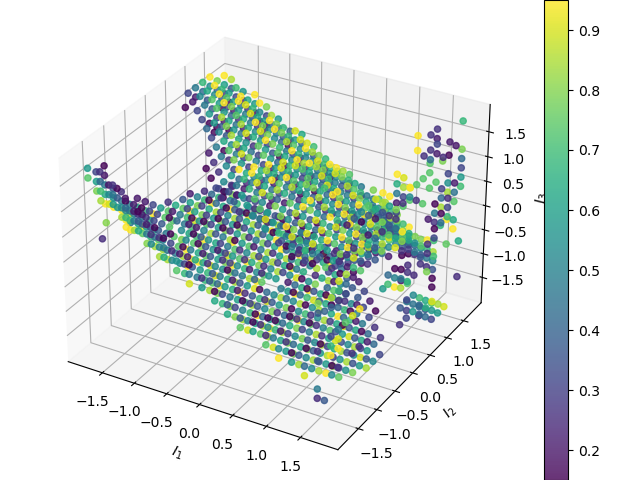

In [14]:
t_weights = []
for t in targets:
    print(vcd.get_cell_type_for_cell(t))
    t_weights.append(getWeights(p, t, degree, l2_reg))

t_weights = np.vstack((t_weights))

In [15]:
t_weights

array([[-2.16030142, -1.39022732, -1.37618579, -2.36889385],
       [-0.32224495,  0.21924242,  0.24700462,  0.4559102 ]])

In [ ]:
I_max = 1.78125
p_n = 0.5
T_n = np.log(p_n / (1 - p_n))

x = cp.Variable(3)

constraints = [
    nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
    x <= I_max,
    -I_max <= x, 
]

objective_function = -t_weights[0, 0] - t_weights[0,1:] @ x

objective = cp.Minimize(objective_function)
prob = cp.Problem(objective, constraints)
opt_val  = prob.solve()
print(f"Optimal value {opt_val}")

In [ ]:
1/(np.exp(opt_val)+1)

In [ ]:
x.value

In [ ]:
I_max = 1.78125

T_t = cp.Variable(1)
T_n = cp.Variable(1)
x = cp.Variable(3)

constraints = [
    -t_weights[0, 0] - t_weights[0,1:] @ x  <= T_t,
    nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
    x <= I_max,
    -I_max <= x, 
]

objective_function = T_n + T_t + 0.2*cp.norm2(x)

objective = cp.Minimize(objective_function)
prob = cp.Problem(objective, constraints)
opt_val  = prob.solve()
print(f"Optimal value {opt_val}")

def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

print(f"optimal p_t {compute_pt(T_t.value)[0]}")
print(f"optimal p_n {compute_pn(T_n.value)[0]}")

In [ ]:
x.value